In [10]:
from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
import numpy.linalg
import scipy.stats as sps

import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.markers
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.axes_grid1 import make_axes_locatable


In [11]:



RED = (0.2, 0, 0, 0.2)
GREEN = (0, 0.2, 0, 0.2)
BLUE = (0, 0, 0.2, 0.2)
NOCOL = (0, 0, 0, 0)

FIGSIZE = (8.5, 3)
MARGINS = {
    "left": 0.1,
    "bottom": 0.15,
    "right": 0.999,
    "top": 0.999
}
CMAP = 'gist_ncar'


def make_ax(fig, is3d):
    return fig.add_subplot(111, projection="3d") if is3d else fig.add_subplot(111)


def setup_ax(ax, **kwargs):
    ax.patch.set_facecolor(NOCOL)

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    if ax.name == "3d":
        ax.set_zlabel(r"$z$")

    if "xlim" in kwargs:
        ax.set_xlim(kwargs["xlim"])
    if "ylim" in kwargs:
        ax.set_ylim(kwargs["ylim"])
    if "zlim" in kwargs:
        ax.set_zlim(kwargs["zlim"])


def make_fig(**kwargs):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(**MARGINS)
    fig.patch.set_facecolor(NOCOL)
    return fig


def CreateFig(**kwargs):
    fig = make_fig(**kwargs)

    ax = make_ax(
        fig, is3d="projection" in kwargs and kwargs["projection"] == "3d")
    setup_ax(ax, **kwargs)

    return fig, ax


In [12]:
NUM_ACTIVES = 3
STATES = {
    "хорошее(подъем)": 1,
    "среднее(равновесие)": 2,
    "плохое(спад)": 3
}

columns = [
    r"вероятность. $p(s)$",
    r"доходность 1, $\rho_1$",
    r"доходность 2, $\rho_2$",
    r"доходность 3, $\rho_3$"
]
data = [[0.3, 0.6, 0.1],
        [20, 20, 5],
        [30, 5, -20],
        [-10, 15, 15]]

PD_df = pd.DataFrame(dict(zip(columns,data)), index=STATES.keys())
display(Markdown(PD_df.to_markdown()))

|                     |   вероятность. $p(s)$ |   доходность 1, $\rho_1$ |   доходность 2, $\rho_2$ |   доходность 3, $\rho_3$ |
|:--------------------|----------------------:|-------------------------:|-------------------------:|-------------------------:|
| хорошее(подъем)     |                   0.3 |                       20 |                       30 |                      -10 |
| среднее(равновесие) |                   0.6 |                       20 |                        5 |                       15 |
| плохое(спад)        |                   0.1 |                        5 |                      -20 |                       15 |

In [13]:
def Get_prob_Index(df, prob_col=1, cols=[]):
    indexes_col = []
    values_col = []
    for col in cols:
        sizes = PD_df[col].value_counts(
            ascending=False).values

        indexes = PD_df[col].sort_values(
            ascending=False).index

        prob_indexes = []
        n1, n2 = 0, 0
        for size in sizes:
            n2 += size
            prob_indexes.append(indexes[n1:n2])
            n1 = n2
        indexes_col.append([df.loc[id][prob_col].sum() for id in prob_indexes])
        values_col.append([df.loc[id][col].values[0] for id in prob_indexes])
    return indexes_col, values_col


probs, vals = Get_prob_Index(PD_df, PD_df.columns[0],  PD_df.columns[1:])
prob_df = pd.DataFrame([probs, vals], index=[
                       r"$\mathcal P$", "values"], columns=columns[1:])
display(Markdown(prob_df.to_markdown()))


|              | доходность 1, $\rho_1$    | доходность 2, $\rho_2$   | доходность 3, $\rho_3$   |
|:-------------|:--------------------------|:-------------------------|:-------------------------|
| $\mathcal P$ | [0.8999999999999999, 0.1] | [0.3, 0.6, 0.1]          | [0.7, 0.3]               |
| values       | [20, 5]                   | [30, 5, -20]             | [15, -10]                |

In [14]:
def Get_distr(c):
    return sps.rv_discrete(values=(c.iloc[1], c.iloc[0]))
def Get_exppayoff(c):
    return c.iloc[2].mean()

def Get_var(c):
    return c.iloc[2].var()


prob_df.loc[r"distribution"] = prob_df.apply(Get_distr)
prob_df.loc[r"$\mathbb E$"] = prob_df.apply(Get_exppayoff)
prob_df.loc[r"$\mathbb D$"] = prob_df.apply(Get_var)
display(Markdown(prob_df.to_markdown()))


|              | доходность 1, $\rho_1$                                                     | доходность 2, $\rho_2$                                                     | доходность 3, $\rho_3$                                                     |
|:-------------|:---------------------------------------------------------------------------|:---------------------------------------------------------------------------|:---------------------------------------------------------------------------|
| $\mathcal P$ | [0.8999999999999999, 0.1]                                                  | [0.3, 0.6, 0.1]                                                            | [0.7, 0.3]                                                                 |
| values       | [20, 5]                                                                    | [30, 5, -20]                                                               | [15, -10]                                                                  |
| distribution | <scipy.stats._distn_infrastructure.rv_sample object at 0x00000197A3157590> | <scipy.stats._distn_infrastructure.rv_sample object at 0x00000197A31566F0> | <scipy.stats._distn_infrastructure.rv_sample object at 0x00000197A30E6630> |
| $\mathbb E$  | 18.5                                                                       | 10.0                                                                       | 7.5                                                                        |
| $\mathbb D$  | 20.249999999999943                                                         | 225.0                                                                      | 131.25                                                                     |

In [15]:
from itertools import combinations


def Get_choice(m, sigma):
    if m[0] > m[1]:
        if sigma[0] < sigma[1]:
            return 0
        elif sigma[0] == sigma[1]:
            return 0
        else:
            return -1
    elif m[0] == m[1]:
        if sigma[0] < sigma[1]:
            return 0
        elif sigma[0] == sigma[1]:
            return 0
        else:
            return 1
    elif m[0] < m[1]:
        if sigma[0] < sigma[1]:
            return -1
        elif sigma[0] == sigma[1]:
            return 1
        else:
            return 1


sigma = list(combinations(prob_df.iloc[4], 2))
m = list(combinations(prob_df.iloc[3], 2))
cols = list(combinations(prob_df.columns, 2))
for i in range(len(cols)):
    if (n := Get_choice(m[i], sigma[i]) == -1):
        display(Markdown(f"{cols[i][0]},"+f" {cols[i][1]} " + "не сравнимы "))

    else:
        display(Markdown(f"{cols[i][n]} более предпочтительна чем {cols[i][1-n]} "))


доходность 1, $\rho_1$ более предпочтительна чем доходность 2, $\rho_2$ 

доходность 1, $\rho_1$ более предпочтительна чем доходность 3, $\rho_3$ 

доходность 2, $\rho_2$, доходность 3, $\rho_3$ не сравнимы 

In [16]:

def check_partition(y):
    if not isinstance(y, (np.ndarray, np.generic)): raise(TypeError)
    if sum(y)<0.99999: raise("Asset portfolio must be normalized")
    return y

def asset_portfolio(y: np.array,*, rho: np.array, m: np.array, cov: np.matrix) -> None:
    r"""
    Портфель активов - вектор распределения долей капитала (y1,y2,...,yn), 
    ∑yk = 1

    yi = Wi°/W°, W° - общий капитал, Wi° - стоимость чатси  i портфеля

    Нужно рассчитать доходность портфеля, одижаемаю доходность портфеля, риск.

    Parameters
    ----------
    rho : np.array
        вектор доходностей
    m : np.array
        мат. ожидание вектора доходностей
    cov : np.matrix
        матрица ковариации доходностей
    """
    check_partition(y)
    rho_y = float(rho@y.T)     if isinstance(rho,  (np.ndarray, np.generic)) else None
    Ey =    float(m@y.T)       if isinstance(m,    (np.ndarray, np.generic)) else None
    Dy =    float(y@cov@y.T)   if isinstance(cov,  (np.ndarray, np.generic)) else None
    return rho_y, Ey, Dy


---------------------------------

**ПРИМЕР 3.1**

In [17]:
y = np.zeros(6)
rho = None
m = np.array([11, 10, 9, 8, 7, 6])
cov = np.diag([4, 3, 1, 0.8, .07, 0.7])**2
df = pd.DataFrame(index=[r"$m$", r"$\sigma$"]).rename_axis(
    r'$n$').rename_axis("bar", axis="columns")

for n in range(2, 7):

    y[:n] = 1
    rho_y, Ey, Dy = asset_portfolio(
        y/n,
        rho=rho,
        m=m,
        cov=cov
    )

    df[n] = [Ey, np.sqrt(Dy)]

    if n == 2:
        Ey2 = Ey
        Dy2 = Dy
display(Markdown(
    f"изменение на шаге m={n}: " +
    r" $\frac{m_2}{m} =$ " +
    f"  {Ey2/Ey:.2f}," +
    r" $ \frac{\sigma_2}{\sigma_m} =$ " +
    f"{np.sqrt(Dy/Dy2):.2f}"
))

display(Markdown(f"m={n}:" +
                 r" $\mathbb E y=$ " +
                 f"{Ey:.1f}" +
                 r" $\mathbb D y=$ " +
                 f"{np.sqrt(Dy):.2f}"))

display(Markdown(df.to_markdown()))

изменение на шаге m=6:  $\frac{m_2}{m} =$   1.24, $ \frac{\sigma_2}{\sigma_m} =$ 0.35

m=6: $\mathbb E y=$ 8.5 $\mathbb D y=$ 0.87

| $n$      |    2 |        3 |       4 |       5 |        6 |
|:---------|-----:|---------:|--------:|--------:|---------:|
| $m$      | 10.5 | 10       | 9.5     | 9       | 8.5      |
| $\sigma$ |  2.5 |  1.69967 | 1.29035 | 1.03237 | 0.868186 |

-----------------------------

**ПРИМЕР 3.2**

Изменения курсов двух акций энергетической $\Delta_\textit{Э}$ и нефтяной компании $\Delta_\textit{Н},$ пропорциональны изменению цены на нефть $\Delta$ с различными коэф-ми.

$\Delta_\textit{Э} = 0.8 \cdot \Delta, \;\; \Delta_\textit{Н} = 0.2 \cdot \Delta.$

Определены начальные стоимости активов $W^0_\textit{Н}, \;\; W^0_\textit{Н} \Rightarrow $ определим доходности 
$$
\rho_\textit{Н} = \frac{\Delta_\textit{Н}}{W^0_\textit{Н}},\;\;
\rho_\textit{Э} = \frac{\Delta_\textit{Э}}{W^0_\textit{Э}}
$$

$$
\frac{\rho_\textit{Э}}{\rho_\textit{Н}} = \frac{\Delta_\textit{Э}W^0_\textit{Н}}{\Delta_\textit{Н}W^0_\textit{Э}} = 4 \frac{W^0_\textit{Н}}{W^0_\textit{Э}} = a\;\; \Rightarrow \rho_\textit{Э} = a \cdot\rho_\textit{Н}
$$

$$
Cov = 
\left(
\begin{smallmatrix}
a^2 & a\\
a & 1
\end{smallmatrix}
\right) \mathbb D_\textit{Н}
$$

C:\Users\Stationary_PC\AppData\Local\Temp\ipykernel_12116\1955407685.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Dy =    float(y@cov@y.T)   if isinstance(cov,  (np.ndarray, np.generic)) else None


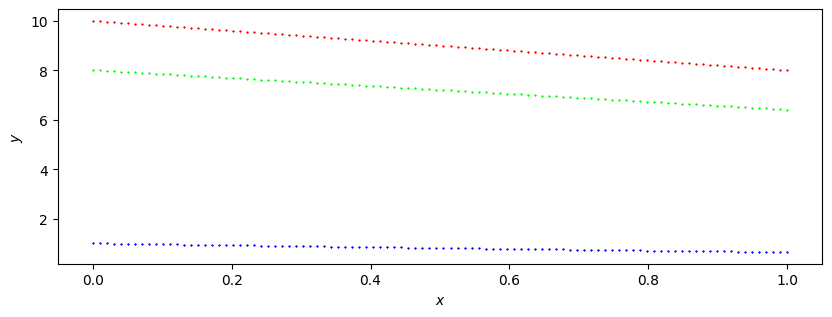

In [18]:
a = 0.8
h = np.array([a, 1])
rho = h*10
m = h*8
cov = np.matrix([[a*a, a], [a, 1]])

d = np.linspace(0, 1, 100)
ys = np.zeros(shape=(100, 2))
ys[:, 1] = d
ys[:, 0] = 1-d


fig, ax = CreateFig()

for y in ys:
    rho_y, Ey, Dy = asset_portfolio(
        y,
        rho=rho,
        m=m,
        cov=cov
    )
    ax.plot(y[0], rho_y,"*-", color=(1, 0, 0), linewidth = 1, markersize= 1)
    ax.plot(y[0], Ey,   "*-", color=(0, 1, 0), linewidth = 1, markersize= 1)
    ax.plot(y[0], Dy,   "*-", color=(0, 0, 1), linewidth = 1, markersize= 1)

In [19]:
def asset_portfolio_short_stack(W0, Wb, *, y: np.array, rho: np.array, m: np.array, cov: np.matrix):
    return asset_portfolio(np.append(y, Wb/W0),rho=rho,m=m,cov=cov)


# Модель Блэка

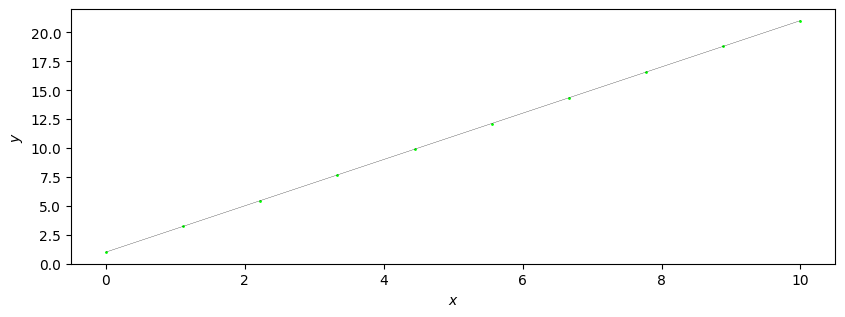

In [20]:
fig, ax = CreateFig()
N = 10
m = np.array([1, -1])
u = np.linspace(0, N, N)
ys = np.zeros(shape=(N, 2))
ys[:, 0] = 1+u
ys[:, 1] = -u
for y in ys:
    _, Ey, _ = asset_portfolio(y, m=m, cov=None, rho=None)
    ax.plot(-y[1], Ey,   "o", color=(0, 1, 0), markersize=1)

ax.plot(-ys[:, 1],  1 - 2*ys[:, 1], color=(0,0,0), linewidth = 0.2)


# МОДЕЛЬ МАРКОВИЦА

------------------

нарисовать графики при разных параметрах

In [21]:

def ellipse(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    theta = np.linspace(0, 2*np.pi, size)
    X[:, 0] = a*np.cos(theta)
    X[:, 1] = b*np.sin(theta)
    return X


def hyperbola(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    Y = np.zeros(shape=(size, 2))
    theta = np.linspace(-2, 2, size)
    X[:, 0] = a*np.cosh(theta)
    X[:, 1] = b*np.sinh(theta)

    Y[:, 0] = -a*np.cosh(theta)
    Y[:, 1] = b*np.sinh(theta)

    return np.vstack((X, Y))


def intersect_lines(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    Y = np.zeros(shape=(size, 2))
    theta = np.linspace(-1, 1, size)
    X[:, 0] = np.linspace(-1, 1, size)
    X[:, 1] = -a/b * X[:, 0]

    Y[:, 0] = np.linspace(-1, 1, size)
    Y[:, 1] = a/b * X[:, 0]

    return np.vstack((X, Y))


def trans_canonic_curve(A, B, C, D, E, F, size=100):
    """ 
    уравнение вида Ax^2+2Bxy+Cy^2+2Dx+2Ey+F=0
    """

    # определяем сдвиг (в случае det!=0)
    x0 = np.linalg.solve(
        a=np.matrix(np.matrix([[A, B], [B, C]])),
        b=np.array([-D, -E]).reshape((-1, 1))
    )
    D_ = (A*x0[0]*x0[0] + C*x0[1]*x0[1]) + (2*D*x0[0] + 2*E*x0[1]) + F
    # новое уравнение Au^2+2Buv+Cv^2+D_=0
    x0 = x0.T

    if B:
        # случаи B!=0 не рассматриваем (но вообще по ккоду выше написаны матрицы поворота)
        return None

    # нормируем уравнение Au^2+Cv^2+D_=0

    if not (A*C):
        return None  # случаи A*C==0 не рассматриваем

    if A*C > 0:
        if A*D_ < 0:
            # эллипс
            a, b = np.sqrt(-D_/A), np.sqrt(-D_/C)
            return Ellipse(a, b, size) + x0
        elif A*D_ > 0:
            return np.array([0, 0]).reshape(-1, 1)  # точка
        elif not (D_):
            print("пара пересекающихся мнимых прямых")
            return None
    elif A*C < 0:
        if A*D_ < 0:
            # гипербола
            a, b = np.sqrt(-D_/A), np.sqrt(D_/C)
            return hyperbola(a, b, size) + x0
        elif A*D_ > 0:
            # гипербола
            a, b = np.sqrt(D_/A), np.sqrt(-D_/C)
            return hyperbola(a, b, size) + x0
        else:
            # |A|u^2-|C|v^2=0
            a, b = np.sqrt(np.abs(A)), np.sqrt(np.abs(C))
            return intersect_lines(a, b, size) + x0

# Можно конечно прозе все решить...
# from sympy import plot_implicit, Eq
# from sympy.abc import x, y
# a = -1
# b = 3
# plot_implicit(Eq((y - a * x) * (y - b * x), -1), (x, -10, 10), (y, -10, 10))


# ЕЩЕ ПРОЩЕ (не нашел сразу)
# https://mmas.github.io/conics-matplotlib


def get_det(A, B, C):
    return np.linalg.det(np.matrix([[A, B], [B, C]]))


def get_det1(A, B, C, D, E, F):
    return np.linalg.det(np.matrix([[A, B, D], [B, C, E], [D, E, F]]))


def dkm(m: np.array, cov: np.matrix, fig, ax):
    sigma = np.sqrt(cov.diagonal())
    r12 = cov[0, 1]/np.prod(sigma)
    A = -pow(m[0]-m[1], 2)
    B = 0
    C = pow(sigma[0]-sigma[1], 2) + 2*(1-r12)*sigma[0]*sigma[1]
    D = 0
    E = (m[0]+m[1])*r12*sigma[0]*sigma[1]-m[1] * \
        pow(sigma[0], 2) - m[0]*pow(sigma[1], 2)
    F = pow(m[1]*sigma[0], 2) + pow(m[0]*sigma[1], 2) - \
        2*m[0]*m[1]*r12*sigma[0]*sigma[1]

    det = get_det(A, B, C)
    det1 = get_det1(A, B, C, D, E, F)

    if not (det):
        return
    # РИСУНОК
    x = trans_canonic_curve(A, B, C, D, E, F, size=10000)
    if not (x is None):
        x = x[x[:, 1] < max(m)]
        x = x[x[:, 1] > min(m)]
        x = x[x[:, 0] < max(sigma)**2]
        x = x[x[:, 0] > 0]

        ax.plot(x[:, 0], x[:, 1])

    if -1 < r12 and r12 < 1:
        print("рисуем гиперболу по коэффициентам")
    elif r12 == 1:
        pass
        # считаем det и det1
        if sigma[0] == sigma[1]:
            print("прямая")
        else:
            print("две прямых (пересекающихся)")
    elif r12 == -1:
        # считаем det и det1
        print("две прямых (пересекающихся)")

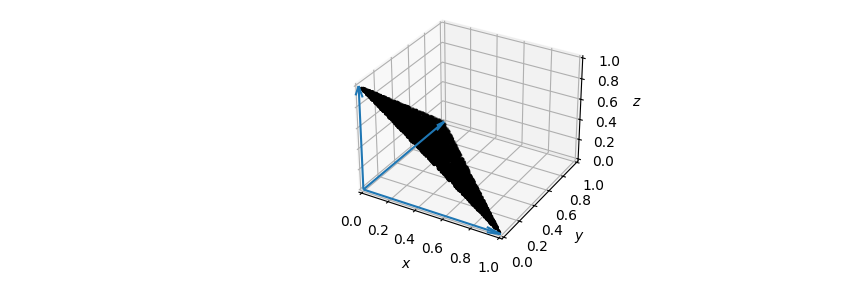

In [22]:
%matplotlib ipympl
# ROTATION
# theta_x = np.radians(45)
# rot_matrix_x = np.array([
#     [1, 0,                              0],
#     [0, np.cos(theta_x), -np.sin(theta_x)],
#     [0, np.sin(theta_x), np.cos(theta_x)]
# ])
# theta_y = np.radians(45)
# rot_matrix_y = np.array([
#     [np.cos(theta_x), 0,  np.sin(theta_x)],
#     [0,              1,                 0],
#     [-np.sin(theta_x), 0,    np.cos(theta_x)]
# ])
# theta_z = np.radians(-45)
# rot_matrix_z = np.array([
#     [np.cos(theta_x), -np.sin(theta_x), 0],
#     [np.sin(theta_x), np.cos(theta_x), 0],
#     [0,            0,                  1]
# ])
# https://math.stackexchange.com/questions/351472/3d-matrix-rotation



SIZE = 10000
X = np.zeros(shape=(SIZE, 3))
X[:, 0] = npr.uniform(0, 1, SIZE)
X[:, 1] = npr.uniform(0, 1, SIZE)
X[:, 2] = 1 - X[:, 0] - X[:, 1]


X = X[X[:, 2] > 0] # если выбираем модель марковица
#X = rot_matrix_x@rot_matrix_y@rot_matrix_z@X


fig,ax = CreateFig(projection="3d", xlim = (0,1),ylim = (0,1),zlim = (0,1))

ax.scatter(X[:, 0],X[:, 1],X[:, 2], color = (0,0,0,1), s = 2)

# draw axis
x, y, z = np.zeros((3,3))
u, v, w = np.array([[1,0,0],[0,1,0],[0,0,1]])
ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1)


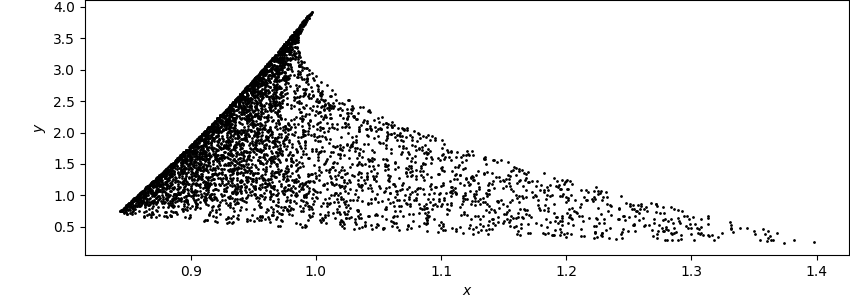

In [23]:
m = np.array([1, 0.2, 4])
cov = np.array([[1, 0.1, 0.9], [0.1, 2, 0.8], [0.9, 0.8, 1]])
E = X@m
D = np.sqrt([x@cov@x.T for x in X])
fig, ax = CreateFig()
ax.scatter(D, E, s=1, color = (0,0,0))



рисуем гиперболу по коэффициентам


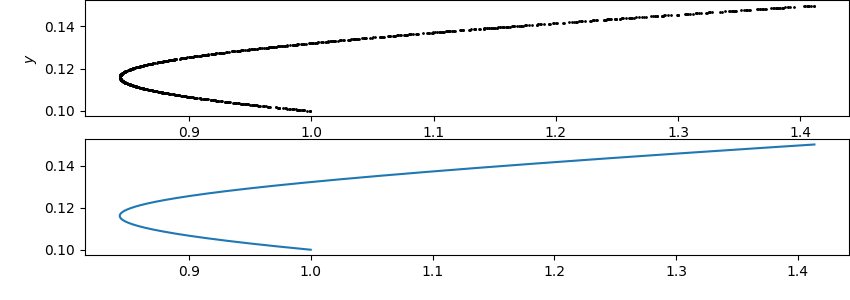

In [24]:
SIZE = 1000
X = np.zeros(shape=(SIZE, 2))
X[:, 0] = npr.uniform(0, 1, SIZE)
X[:, 1] = 1 - X[:, 0]

m = np.array([0.1, 0.15])
cov = np.array([[1, 0.1], [0.1, 2]])
E = X@m
D = np.sqrt([x@cov@x.T for x in X])
fig, ax = CreateFig()
ax.scatter(D, E, s=1, color=(0, 0, 0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", "100%", pad="20%")
dkm(m, cov, fig, cax)


две прямых (пересекающихся)


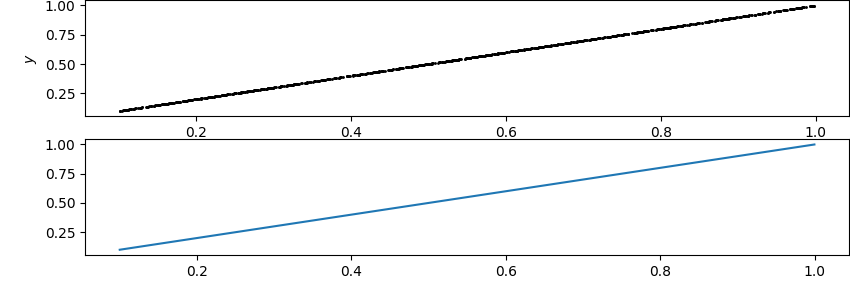

In [25]:
a = 0.1
h = np.array([a, 1])
m = h
cov = np.array([[a*a, a], [a, 1]])
E = X@m
D = np.sqrt([x@cov@x.T for x in X])
fig, ax = CreateFig()
ax.scatter(D, E, s=1, color=(0, 0, 0))


divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", "100%", pad="20%")
dkm(m, cov, fig, cax)


----------------

**Модель Блэка**


**НАЙТИ** распределение долей капитала в портфеле $\textbf y,$ с фиксированной ожидаемой доходностью $\textbf m$ :
$\textbf y^T\textbf m = m^*$


$\newcommand{\COV}[1]{{\boldsymbol{COV}}}$

и **МИНИМИЗИРОВАТЬ** риск портфеля $\textbf y^T \COV \textbf y \to \min\limits_{\textbf y}$ 


Модель Блэка задана $\sum\limits_{i=1}^n y_i = 1$, т.е. может описывать портфель  с учетом коротких позиций $\sum\limits_{i=1}^{n+1} y_i = 1, $ где $y_{n+1} = \frac{W^b}{W^0},$  $W^b$ - цена актива с короткой позиции (заемный капитал), $W^0$ - свой капитал



перепишем задачу в виде:
$\begin{equation}
\begin{cases}
\textbf y^T \COV \textbf y \to \min\limits_{\textbf y},\\
\textbf y^T\textbf m = m^*,\\
\mathbf I^T \textbf y = 1.\\
\end{cases}
\end{equation}$


In [26]:
import warnings


def check_degenerate(m: np.ndarray):
    """ 
    проверка вырожденного случая
    m_1 = m_2 = ... m_n = = m*
    """
    return (m == m[0]).all()


def draw_risk_revenue_rel(cov_1, m_1, m_, I, A, B, C):
    k1 = (A*m_ - C*I)/(C*C-B*A)
    k2 = (B*I - m_*C)/(C*C-B*A)
    a = float(k1.T@cov_1@k1)
    b = float(k2.T@cov_1@k1)
    c = float(k2.T@cov_1@k2)

    parabola = np.vectorize(lambda x: a*pow(x, 2) + 2* b * x + c)
    x = np.linspace(0, 0.2, 100)
    y = parabola(x)
    fig, ax = CreateFig()
    ax.set_xlabel(r"$\mathbb{E}$")
    ax.set_ylabel(r"$\sigma$")
    ax.plot(x, y, label = "эффективная граница", color= (0,0,1))
    ax.vlines(-b/a,y.min(),y.max(), label="минимальный риск", color = (1,0,0))
    ax.legend()

def not_deg_sol(cov_1, m_1, m_, I, A, B, C):
    return -cov_1@(m_1*(A*m_ - C*I) + B*I - m_*C)/(C*C-B*A)


def deg_sol(cov_1, I, A):
    return cov_1@I/A


def disable_warnings(func):
    def inner(*args, **kwargs):
        warnings.simplefilter("ignore")
        res = func(*args, **kwargs)
        warnings.simplefilter("default")
        return res
    return inner


@disable_warnings
def solution(m: np.ndarray, cov: np.matrix, draw: bool = False):
    m_ = m.reshape(-1, 1)
    I = np.ones(shape=m_.shape)

    m_1 = float(I.T@m_)
    cov_1 = np.linalg.inv(cov)

    A = float(I.T@cov_1@I)
    B = float(m_.T@cov_1@m_)
    C = float(I.T@cov_1@m_)

    sol = deg_sol(cov_1, I, A) if check_degenerate(
        m) else not_deg_sol(cov_1, m_1, m_, I, A, B, C)

    if draw:
        draw_risk_revenue_rel(cov_1, m_1, m_, I, A, B, C)

    return sol

array([[-0.66666667],
       [ 1.66666667]])

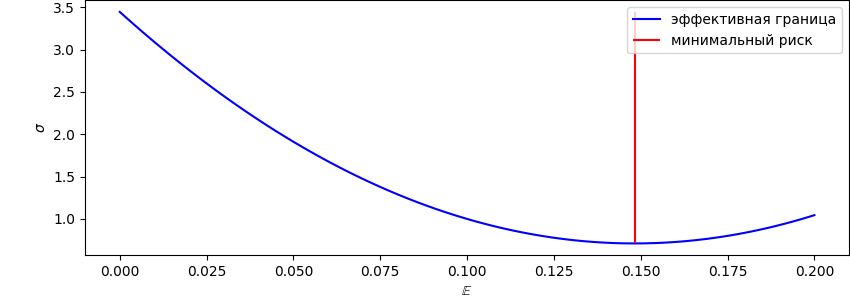

In [27]:
m = np.array([0.1, 0.25])
cov = np.array([[1, 0.1], [0.1, 2]])
solution(m,cov,True)

array([[ 4.60300043],
       [-3.76638328],
       [ 0.16338286]])

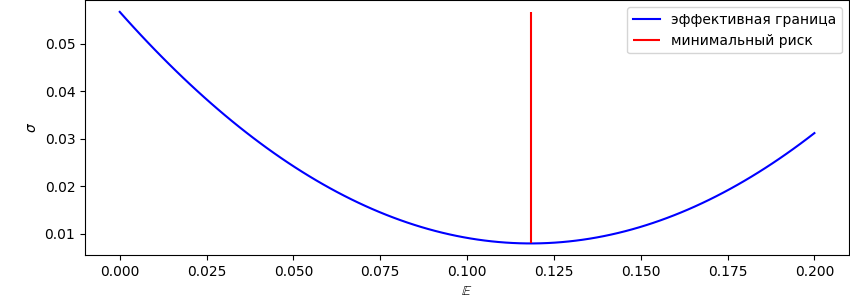

In [28]:
m = np.array([0.2553, 0.1675, 0.1452])
cov = np.array([
    [.08,0.039,0.008],[0.039, 0.025, -0.002],[0.008,-0.002,0.035],
])
solution(m,cov,True)

--------------------------

**Модель Марковица**

**Метод критических линий**